# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, SelectKBest

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
print 'Unique income values:', np.unique(data['income'])

Unique income values: ['<=50K' '>50K']


In [3]:
# TODO: Total number of records
n_records = len(data.index)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 1.*n_greater_50k/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(100. * greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

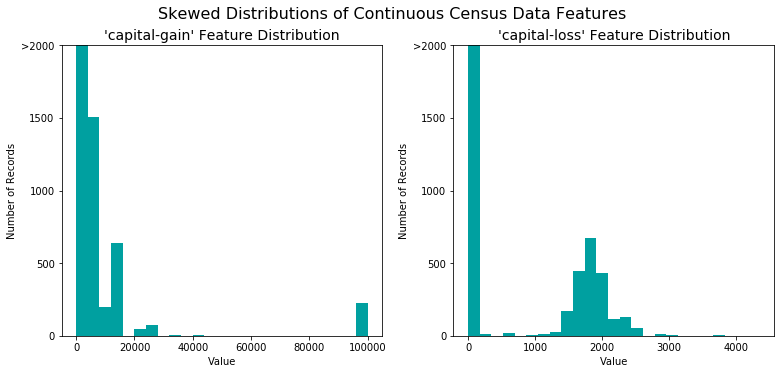

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

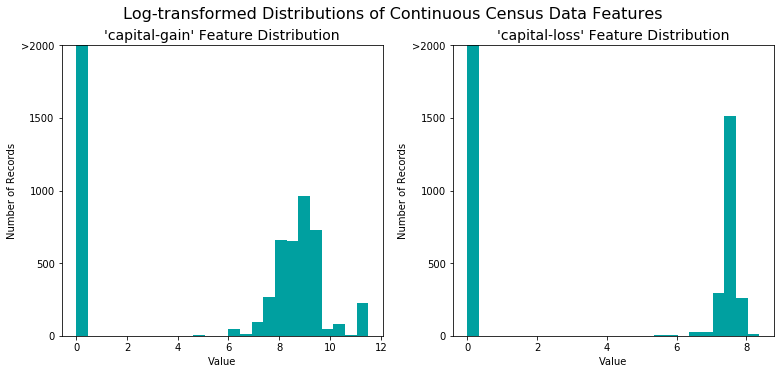

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [8]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/home/buzz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
# TODO: Calculate accuracy
accuracy = 1. * n_greater_50k / n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = .5
true_positives, false_positives, false_negatives = n_greater_50k, n_at_most_50k, 0
precision = 1. * true_positives / (true_positives + false_positives)
recall = 1. * true_positives / (true_positives + false_negatives)
fscore = (1 + beta**2) * precision * recall / (beta**2 * precision + recall)

print "Precision: %.4f, recall: %.4f" % (precision, recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Precision: 0.2478, recall: 1.0000
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** It was hard for me to choose algorithms without knowing anything about the data so I tried investigating it. (later I provided answer for this question).

There are 103 colums as a result of one-hot encoding categorical data. I assume some of them consist of only couple of occurances of a value i.e. 1s. Since these are binary data let's see the mean of all columns looking for mean close to 0.

In [11]:
def print_features_with_low_mean():
    for col in features.columns:
        mean = np.mean(features[col])
        if mean < .01:
            print 'Feature: %s, mean: %.4f' % (col, mean)

In [12]:
print_features_with_low_mean()

Feature: workclass_ Without-pay, mean: 0.0005
Feature: education_level_ 1st-4th, mean: 0.0049
Feature: education_level_ 5th-6th, mean: 0.0099
Feature: education_level_ Preschool, mean: 0.0016
Feature: marital-status_ Married-AF-spouse, mean: 0.0007
Feature: occupation_ Armed-Forces, mean: 0.0003
Feature: occupation_ Priv-house-serv, mean: 0.0051
Feature: race_ Amer-Indian-Eskimo, mean: 0.0096
Feature: race_ Other, mean: 0.0078
Feature: native-country_ Cambodia, mean: 0.0006
Feature: native-country_ Canada, mean: 0.0036
Feature: native-country_ China, mean: 0.0025
Feature: native-country_ Columbia, mean: 0.0018
Feature: native-country_ Cuba, mean: 0.0029
Feature: native-country_ Dominican-Republic, mean: 0.0021
Feature: native-country_ Ecuador, mean: 0.0010
Feature: native-country_ El-Salvador, mean: 0.0033
Feature: native-country_ England, mean: 0.0026
Feature: native-country_ France, mean: 0.0008
Feature: native-country_ Germany, mean: 0.0043
Feature: native-country_ Greece, mean: 0.0

**Conclusion:** indeed there are many categorical columns with low mean.

Sklearn has feature selector based on variance threshold (note: I grouped imports at the beginning of the notebook so that the code it more readable). It also removes features with zero variance.

Let's see how many features are removed given variance threshold.

In [13]:
def remove_features_with_low_var(var = .9):
    vt = VarianceThreshold(threshold=var * (1 - var))
    return vt.fit_transform(X_train)

In [14]:
print 'Original data  :', X_train.shape
print 'Var .99 removed:', remove_features_with_low_var(.99).shape
print 'Var .9 removed :', remove_features_with_low_var(.9).shape

Original data  : (36177, 103)
Var .99 removed: (36177, 53)
Var .9 removed : (36177, 20)


** Conclusion:** removing features which are 0 or 1 in more than 99% of samples results in only 53 featues left. With 90% we get 20 features.

Sklearn has also k best selector. I noticed selector returns scores for features so let's explore them. (Note: k parameter is less important here as we want to only get scores).

In [15]:
def plot_feature_scores():
    not_important_really = 20
    selector = SelectKBest(k = not_important_really)
    res = selector.fit_transform(X_train, y_train)
    plt.plot(selector.scores_)

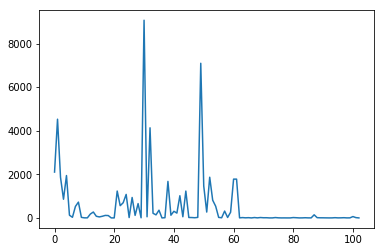

In [16]:
plot_feature_scores()

** Conclusion:** roughly 60% of features seem to be somehow important.

It's hard to visualize all the features. Let's try TSNE which allows ploting high dimentional data in 2D.

In [17]:
def plot_tsne(X, y):
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    t = tsne.fit_transform(X)
    plt.scatter(t[:,0], t[:,1], c = y, marker='.', alpha=0.5)

#### All features for first 1000 samples

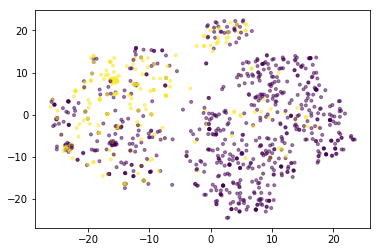

In [18]:
plot_tsne(features[0:1000], income[0:1000])

#### 20 features for first 1000 samples

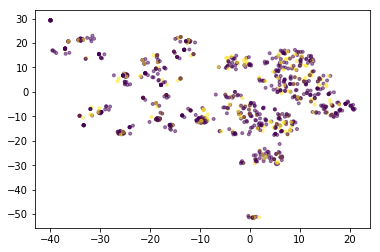

In [19]:
var9 = remove_features_with_low_var(.9)
plot_tsne(var9[0:1000], income[0:1000])

**Conclusion**: samples of both classes are sometimes close in 2D which means there are close in high parameter space. Reducing number of features creates lumps of data but I wonder how this would impact classifier?

** Answer ** Given the data exploration I'm chossing
1. Random Forest 
    * real-world application: network traffic filtering based on some rules (as I remember correctly linux and most routers uses this approach); eCommers - predicting click through
    * *strengths:* has advantages of decision trees: can be visualized; can fit corner cases e.g. at some tree level can ask question about categorical value and predict correctly narrow case
    * *weaknesses:* prone to overfit but random forest may mitigate this problem; some concepts like XOR hard to learn
    * *why good candidate:* looking at TSNE the decision boundary in some cases/features my be complicated. Decision tree may be able to address this issue
2. SVC with rbf kernel
    * real-world application: found this paper http://jmlr.csail.mit.edu/papers/volume15/delgado14a/delgado14a.pdf SVC at the top - wow. Google earth engine: https://developers.google.com/earth-engine/classification
    * *strengths:* uses support vectors i.e. can ignore some points and create complicated decision boundaries
    * *weaknesses:* requires proper parameter setting C, gamma. Slow for huge datasets - not sure how will work in this case
    * *why good candidate:* can address complicated domains and is effective in high dimensional spaces which makes it good candidate algorithm given the data
3. Adaboost:
    * real-world application: detecting basketball players: https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf
    * *strengths:* uses lots of weak learners on 'hard to classify samples', tends to prevent overfitting
    * *weaknesses:* probably more time consuming in training and inference; not sure but I think it requires adjusting number of weak learners
    * *why good candidate:* with lots of weak learners can adapt to complicated domain


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [20]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[0:300], predictions_train[0:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[0:300], predictions_train[0:300], .5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, .5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


/home/buzz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


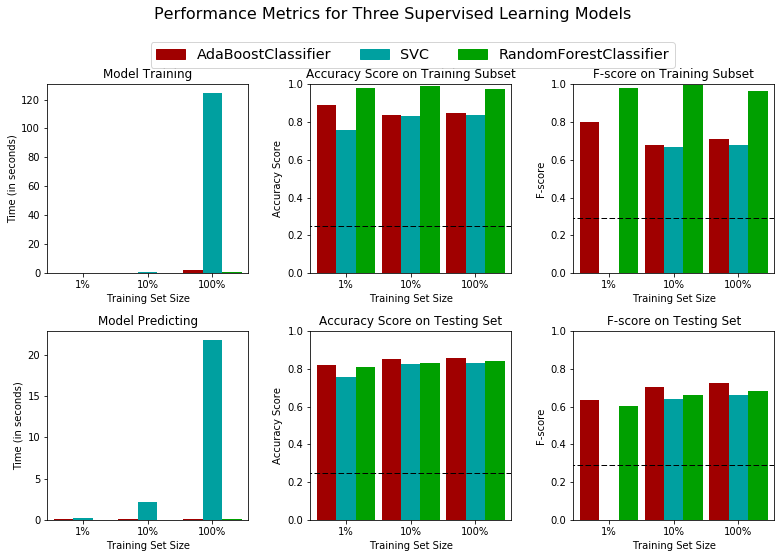

In [21]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = SVC(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(.01 * X_train.shape[0])
samples_10 = int(.1 * X_train.shape[0])
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [22]:
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

AdaBoostClassifier


,1%,10%,100%
acc_test,0.820785,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.633010,0.701882,0.724551
f_train,0.801282,0.680147,0.711538
pred_time,0.102196,0.102292,0.103099
train_time,0.207809,0.294357,1.969482


SVC


,1%,10%,100%
acc_test,0.756219,0.822664,0.830072
acc_train,0.760000,0.833333,0.836667
f_test,0.000000,0.640846,0.659238
f_train,0.000000,0.669643,0.677966
pred_time,0.247317,2.159254,21.786193
train_time,0.013293,1.086419,124.257593


RandomForestClassifier


,1%,10%,100%
acc_test,0.808402,0.833057,0.843118
acc_train,0.980000,0.993333,0.973333
f_test,0.603772,0.663522,0.684322
f_train,0.982143,0.994318,0.967262
pred_time,0.033898,0.035512,0.048612
train_time,0.085375,0.075968,0.671405


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** All three algorithms performed similarly in terms of test accuracy with AdaBoost scoring 85.8%, RandomForest 84.3% and SVC 83%. However they differ in F1/2 score where AdaBoost reached 0.74, RandomForest 0.68 and SVC 0.66. From this perspective the winner is AdaBoost, close second is RandomForest. 

Apart from that we have to look also at training and testing time. It turned out SVC takes much longer than the other two algorithms, over 100 times during training and over 20 times during inference! Comparing top two models, RandomForest is twice quicker in testing and 3 times in training than AdaBoost at the cost of a bit lower accuracy and F1/2 score. As a result there is a tradeoff: accuracy, F1/2 vs testing/training speed. If the former is more important we should pick AdaBoost if the latter - RandomForest. Of course there is also room for improvement by finetuning algorithms' parameters.

Both algorithms use decision trees but a in different way - RandomForest uses couple of full deep trees i.e. trees that predict classes for all samples at the same time and averaging their output, whereas AdaBoost uses lots of small trees but each tree tackles 'hard' sub-samples. Both seem to deal with nuances of the data, where there are many categorical values which are sparse.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** I chose AdaBoost. 

1. Adaboost combines several simple learners (eg, decision trees) to create an "ensemble" of learners that can predict whether an individual has income above 50K or not.
2. Each of these simple decision trees is created using "features" we have about individuals (eg, age, sex, income, etc.) to essentially create a flowchart of "yes/no" questions. Some of these questions may be simple as: is it a man? or is it a woman?, other may ask: is the age < 40?. The goal is to come up with good questions, wchich after being answered allow learner to to predict income over 50K or not.
3. During several rounds of training, the adaboost model looks at where it predicted badly and puts more attention at those samples in the next round.
4. With each round, the model finds the best learner (decision tree) to incorporate into the ensemble, repeating the process for a predetermined number of rounds.
5. All the learners are then combined to create the final ensembled model where they each "vote" to contribute to the ultimate answer. Their "vote" have different weight since they looked at different piece of data with different attention.
6. Using this model created with existing information of known individuals, we take the features of "new" potential donors and feed them into the ensamble allowing all simple learners to vote. All votes are combined with respective weights to produce final answer whether individual has income above 50K or not.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [23]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))

# TODO: Create the parameters list you wish to tune
parameters = {
    'n_estimators': [50, 100, 125],
    'learning_rate' : [.5, .75, 1.],
    'base_estimator__min_samples_split' : np.arange(2, 8, 2),
    'base_estimator__max_depth' : np.arange(1, 4, 1)
}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer, n_jobs=4, verbose=1)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

clf = AdaBoostClassifier(random_state=42)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/home/buzz/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed: 10.0min finished


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8690
Final F-score on the testing data: 0.7489


I must admit GridSearch took lot of time so I found another params to add: n_jobs, verbose.

I was also curious about the result so I investigated grid\_scores\_ - done below

In [24]:
sorted(grid_fit.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)[0:5]

[mean: 0.75546, std: 0.00435, params: {'n_estimators': 100, 'base_estimator__min_samples_split': 2, 'base_estimator__max_depth': 2, 'learning_rate': 0.5},
 mean: 0.75541, std: 0.00428, params: {'n_estimators': 100, 'base_estimator__min_samples_split': 4, 'base_estimator__max_depth': 2, 'learning_rate': 0.5},
 mean: 0.75533, std: 0.00437, params: {'n_estimators': 100, 'base_estimator__min_samples_split': 6, 'base_estimator__max_depth': 2, 'learning_rate': 0.5},
 mean: 0.75490, std: 0.00420, params: {'n_estimators': 50, 'base_estimator__min_samples_split': 6, 'base_estimator__max_depth': 3, 'learning_rate': 0.5},
 mean: 0.75437, std: 0.00454, params: {'n_estimators': 125, 'base_estimator__min_samples_split': 2, 'base_estimator__max_depth': 2, 'learning_rate': 0.5}]

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              |    0.8576         |    0.8690       |
| F-score        | 0.2917              |    0.7246         |    0.7489       |


**Answer: ** Unoptimized model is way better than benchmark predictor both in terms of accuracy and f-score. Optimized model is slightly better than the unoptimized one - accuracy rose by 0.011 and f-score by 0.024

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** 
1.  education_level	- varies from Preschool, through Masters to Doctorate so it should be strong predictor whether someone completed education and works and if so in what type of job can be working
2. age - similar to point 1 - strong predictor of working and work experience which affects salary
3. occupation - some professions are prone to have better salary
4. hours-per-week - half-time job vs full-time job should influence income
5. capital-gain may indicate wealthier people
 		

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

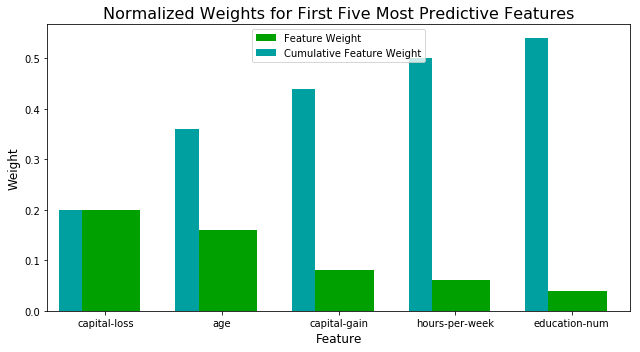

In [25]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
1. capital-loss - I'm not an expert in economy so I don't whether this loss is calculated into income. May be being in red affects income? Definitely this is a strong predictor
2. age - graph confirmed my assumption
3. capital-gain - I order this at 5th place so it's close - thoughts confirmed
4. hours-per-week - as with age, confirmed - same as my prediction
5. education-num - this is very similar to educaton_level - Number of educational years completed - in my opinion my reasoning could be applied here as well. Wonder at what place is education_level?

I tried to see the education_level and got following results below. In my opinion categorical values are underrepresented because one-hot encoding splitted them up into many features. Don't you think they should be aggregated to give better picture?

In [26]:
sorted_idx = np.argsort(importances)[::-1]
pd_importance = pd.DataFrame([(importances[idx], X_train.columns.values[idx]) for idx in sorted_idx], columns= ['Importance', 'Name'])
pd_importance.head(n=10)

,Importance,Name
0,0.20,capital-loss
1,0.16,age
2,0.08,capital-gain
3,0.06,hours-per-week
4,0.04,education-num
5,0.04,education_level_ Bachelors
6,0.02,race_ White
7,0.02,education_level_ Masters
8,0.02,occupation_ Tech-support
9,0.02,marital-status_ Married-AF-spouse


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [27]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8690
F-score on testing data: 0.7489

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.7008


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** Both accuracy and f-score are a bit lower. I tried to calculate execution time (done below). Training time is almost 3 times faster, inference is 1.48 times faster Taking into account training time as a factor I would narrow features and sucrifice accuracy and f-score. Of course we could try adding a few 'important' features back to see whether we can bump accuracy yet stay in the same efficiency regime. Another idea: during testing other algorithms RandomForest looked promising - similar accuracy, f-score to the AdaBoost yet even quicker - so if training/testing speed is main factor we could try tunning RandomForest and reduce features.

In [28]:
clf = clone(best_clf)
%time clf = (clf).fit(X_train_reduced, y_train)
%time clf.predict(X_test_reduced)

CPU times: user 2.11 s, sys: 0 ns, total: 2.11 s
Wall time: 2.11 s
CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 135 ms


array([0, 0, 0, ..., 0, 0, 1])

In [29]:
clf = clone(best_clf)
%time clf = (clf).fit(X_train, y_train)
%time clf.predict(X_test)

CPU times: user 6.84 s, sys: 0 ns, total: 6.84 s
Wall time: 6.86 s
CPU times: user 196 ms, sys: 0 ns, total: 196 ms
Wall time: 196 ms


array([0, 0, 0, ..., 0, 0, 1])

In [30]:
print 'Speed up train:', 6.25 / 2.11, 'inference:', .196 / .132


Speed up train: 2.96208530806 inference: 1.48484848485


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.